##**Notebook PC#10 - Part 1**

## Generative Adversarial Networks for the CIFAR-10 dataset.

Based on [this content](https://towardsdatascience.com/generative-adversarial-networks-bf4e809180b3), with code corrections.

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Taylon Luan Congio Martins RA: 177379<br>
**Aluno(a):** Tiago C A Amorim RA: 100675

Additional ideas from: https://www.tensorflow.org/tutorials/generative/dcgan?hl=pt-br

In [ ]:
# from __future__ import print_function, division

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, InputLayer, Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop

# import sys
import os
import matplotlib.pyplot as plt
import numpy as np
# import matplotlib.image as mpimg
import imageio.v3 as iio
import glob

import time
import random
import itertools

### Common Functions

In [ ]:
def images_grid(imgs, title=None, titles= None, grid_size=(5,5), figsize=(5, 5), normalized=True, file_name=None):
    if normalized:
        imgs = (imgs + 1) * 0.5

    n_imgs = grid_size[0]*grid_size[1]
    fig = plt.figure(figsize=figsize)
    for i in range(n_imgs):
        plt.subplot(grid_size[0], grid_size[1], i+1)
        if i < len(imgs):
            plt.imshow(imgs[i])
            if titles is not None:
                plt.title(titles[i], fontsize=7)
        plt.axis('off')

    if title is not None:
        fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    if file_name is None:
        plt.show()
    else:
        fig.savefig(file_name)
    plt.close()

### Dataset

In [ ]:
# Load the CIFAR-10 dataset
(X_train, y_train), (_, _) = cifar10.load_data()
# Select only the dog class (class 5 in CIFAR-10)
X_train = X_train[y_train.flatten() == 5]
# Rescale -1 to 1
X_train = X_train / 127.5 - 1.

170498071/170498071 [==============================] - 2s 0us/step


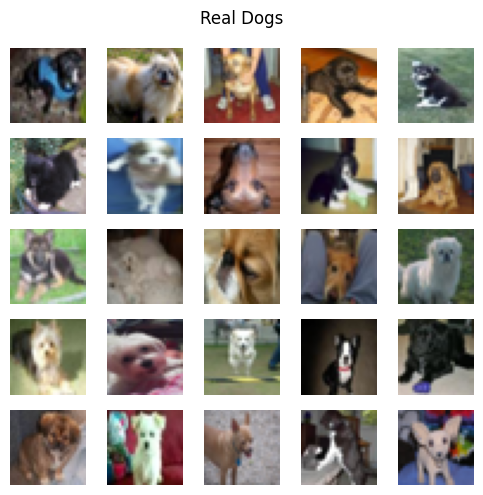

In [ ]:
images_grid(X_train, title="Real Dogs")

### Gan Class

In [ ]:
class GAN():
    def __init__(self,
                 latent_dim,
                 lr=0.001,
                 beta_1=0.8,
                 out_folder='png',
                 disc_acc_limits=(0.5, 0.8),
                 alpha=0.2, momentum=0.8, dropout=0.25,
                 img_grid=(5,5), img_best_search=100):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim

        self.disc_acc_limits = disc_acc_limits
        self.alpha = alpha
        self.momentum = momentum
        self.dropout = dropout

        self.optimizer_disc = Adam(learning_rate=lr, beta_1=beta_1)
        self.optimizer_gen  = Adam(learning_rate=lr, beta_1=beta_1)

        self.folder = f'./{out_folder}'
        if not os.path.exists(self.folder):
            os.makedirs(self.folder)
        else:
            file_list = os.listdir(self.folder)
            for file_name in file_list:
                file_path = os.path.join(self.folder, file_name)
                if os.path.isfile(file_path):
                    os.remove(file_path)

        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()

        self.img_grid = img_grid
        self.img_best_search = img_best_search

        self.d_losses, self.g_losses = [], []
        self.real_acc, self.fake_acc = [], []


    def build_discriminator(self):
        x_input = keras.layers.Input(shape=self.img_shape)
        x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x_input)
        x = LeakyReLU(alpha=self.alpha)(x)
        x = Dropout(self.dropout)(x)
        x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=self.alpha)(x)
        x = Dropout(self.dropout)(x)
        x = Flatten()(x)
        x = Dense(1, activation='sigmoid')(x)
        model = Model(inputs = x_input, outputs = x)
        return model


    def build_generator(self):
        x_input = keras.layers.Input(shape=(self.latent_dim,))
        x = Dense(128 * 8 * 8, activation="relu")(x_input)
        x = Reshape((8, 8, 128))(x)
        x = BatchNormalization(momentum=self.momentum)(x)
        x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=self.alpha)(x)
        x = BatchNormalization(momentum=self.momentum)(x)
        x = Conv2DTranspose(32, kernel_size=4, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=self.alpha)(x)
        x = BatchNormalization(momentum=self.momentum)(x)
        x = Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='tanh')(x)
        model = Model(inputs = x_input, outputs = x)
        return model

    def get_good_fake_dogs(self, n_try, n_dogs):
        sample_noise = np.random.normal(0, 1, (n_try, self.latent_dim))
        gen_imgs = self.generator.predict(sample_noise)
        results = self.discriminator(gen_imgs)
        best = tf.argsort(results, axis=0)[-n_dogs:]
        best_results = tf.sort(results, axis=0)[-n_dogs:][:,0]
        return gen_imgs[best][:,0,:,:], best_results


    def sample_images(self, epoch=None, search_best=1, grid_size=None):
        if grid_size is None:
            grid_size = self.img_grid
        n_dogs = grid_size[0]*grid_size[1]
        gen_imgs, results = self.get_good_fake_dogs(search_best*n_dogs, n_dogs)
        titles = ['Dog' if i > 0.5 else 'Not dog' for i in results]

        if epoch is None:
            images_grid(gen_imgs, titles= titles, grid_size=grid_size)
        else:
            images_grid(gen_imgs,
                        title=f"Epoch = {epoch}",
                        titles= titles,
                        grid_size=grid_size,
                        file_name=f'{self.folder}/{epoch:06d}.png')


    def show_image(self, epoch):
        image = iio.imread(f"{self.folder}/{epoch:06d}.png")
        plt.imshow(image)
        plt.axis('off')
        plt.show()


    def create_gif(self):
        gif_path = f"{self.folder}/fake_dogs.gif"
        filenames = glob.glob(f"{self.folder}/*.png")
        filenames = sorted(filenames)
        frames = np.stack([iio.imread(filename) for filename in filenames], axis=0)
        iio.imwrite(gif_path, frames)


    def save_models(self, epoch):
        self.discriminator.save(f'{self.folder}/Discriminator_{epoch:06d}.keras')
        self.generator.save(f'{self.folder}/Generator_{epoch:06d}.keras')


    def plot_losses(self):
        _ = plt.figure(figsize=(5,5))
        plt.plot(self.d_losses, label='Discriminator')
        plt.plot(self.g_losses, label='Generator')
        plt.legend()
        plt.grid(True)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()


    def plot_acc(self):
        _ = plt.figure(figsize=(5,5))
        plt.plot(self.real_acc, label="Real samples")
        plt.plot(self.fake_acc, label="Fake samples")
        plt.legend()
        plt.grid(True)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy of the Discriminator')
        plt.show()


    def train(self, X_train, epochs, batch_size=128, sample_interval=50, save_interval=50):
        cross_entropy = keras.losses.BinaryCrossentropy()
        accuracy_real = keras.metrics.BinaryAccuracy()
        accuracy_fake = keras.metrics.BinaryAccuracy()


        def discriminator_loss(real_output, fake_output):
            real_loss = cross_entropy(tf.ones_like(real_output), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
            total_loss = real_loss + fake_loss
            accuracy_real.update_state(tf.ones_like(real_output), real_output) #tf.where(real_output > 0.5, 1, 0))
            accuracy_fake.update_state(tf.zeros_like(fake_output), fake_output) #tf.where(fake_output > 0.5, 1, 0))
            return total_loss


        def generator_loss(fake_output):
            # accuracy_fake.update_state(tf.zeros_like(fake_output), fake_output) #tf.where(fake_output > 0.5, 1, 0))
            return cross_entropy(tf.ones_like(fake_output), fake_output)


        # This annotation causes the function to be "compiled".
        @tf.function
        def train_step(images):
            noise = tf.random.normal([batch_size, self.latent_dim])
            with tf.GradientTape() as disc_tape:
                generated_images = self.generator(noise, training=True)
                real_output = self.discriminator(images, training=True)
                fake_output = self.discriminator(generated_images, training=True)
                disc_loss = discriminator_loss(real_output, fake_output)

                gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
                if accuracy_fake.result() < self.disc_acc_limits[1]:
                    self.optimizer_disc.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))


            noise = tf.random.normal([batch_size, self.latent_dim])
            with tf.GradientTape() as gen_tape:
                generated_images = self.generator(noise, training=True)
                fake_output = self.discriminator(generated_images, training=True)
                gen_loss = generator_loss(fake_output)

                gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
                if accuracy_fake.result() > self.disc_acc_limits[0]:
                    self.optimizer_gen.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

            return gen_loss, disc_loss

        def batched(iterable, n):
            # batched('ABCDEFG', 3) → ABC DEF G
            if n < 1:
                raise ValueError('n must be at least one')
            iterator = iter(iterable)
            while batch := tuple(itertools.islice(iterator, n)):
                yield batch

        def _train(dataset, epochs):
            self.d_losses, self.g_losses = [], []
            self.real_acc, self.fake_acc = [], []

            index = list(range(len(dataset)))
            for epoch in range(epochs):
                start = time.time()

                accuracy_real.reset_state()
                accuracy_fake.reset_state()

                g_loss, d_loss = [], []
                random.shuffle(index)
                for i_ in batched(index, batch_size):
                    image_batch = dataset[list(i_)]
                    g_, d_ = train_step(image_batch)
                    g_loss.append(g_)
                    d_loss.append(d_)

                self.d_losses.append(np.mean(d_loss))
                self.g_losses.append(np.mean(g_loss))
                self.real_acc.append(accuracy_real.result())
                self.fake_acc.append(accuracy_fake.result())

                # If at save interval => save generated image samples
                if epoch % sample_interval == 0:
                    self.sample_images(
                        epoch=epoch,
                        search_best=self.img_best_search,
                        grid_size = self.img_grid)

                # Save the model
                if epoch % save_interval == 0:
                    self.save_models(epoch)

                msg = f'Epoch {epoch + 1} | '
                msg += f'Losses: disc={self.d_losses[-1]:0.4g}, gen={self.g_losses[-1]:0.4g} | '
                msg += f'Acc: real={self.real_acc[-1]:0.2g}, fake={self.fake_acc[-1]:0.2g} '
                msg += f'({time.time()-start:0.2f} s)'
                print(msg)

            self.sample_images(epochs)
            self.save_models(epoch)
            self.create_gif()
            print("=========== End ===========")

        return _train(X_train, epochs)

### Tests

Streaming output truncated to the last 5000 lines.
Epoch 5052 | Losses: disc=1.337, gen=0.7486 | Acc: real=0.55, fake=0.61 (1.02 s)
Epoch 5053 | Losses: disc=1.34, gen=0.7809 | Acc: real=0.54, fake=0.61 (1.02 s)
Epoch 5054 | Losses: disc=1.326, gen=0.7606 | Acc: real=0.57, fake=0.6 (1.01 s)
Epoch 5055 | Losses: disc=1.371, gen=0.7551 | Acc: real=0.49, fake=0.6 (1.01 s)
Epoch 5056 | Losses: disc=1.317, gen=0.769 | Acc: real=0.6, fake=0.61 (1.01 s)
Epoch 5057 | Losses: disc=1.319, gen=0.7952 | Acc: real=0.61, fake=0.6 (1.01 s)
Epoch 5058 | Losses: disc=1.356, gen=0.7525 | Acc: real=0.51, fake=0.6 (1.01 s)
Epoch 5059 | Losses: disc=1.36, gen=0.761 | Acc: real=0.51, fake=0.6 (1.01 s)
Epoch 5060 | Losses: disc=1.338, gen=0.759 | Acc: real=0.55, fake=0.62 (1.01 s)
Epoch 5061 | Losses: disc=1.362, gen=0.7466 | Acc: real=0.51, fake=0.6 (1.01 s)
Epoch 5062 | Losses: disc=1.338, gen=0.7585 | Acc: real=0.54, fake=0.61 (1.01 s)
Epoch 5063 | Losses: disc=1.345, gen=0.7611 | Acc: real=0.52, fake=0.6

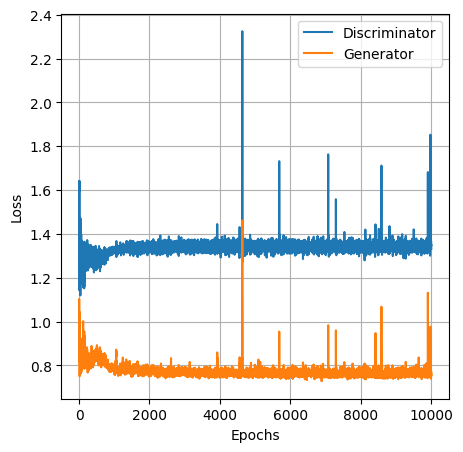

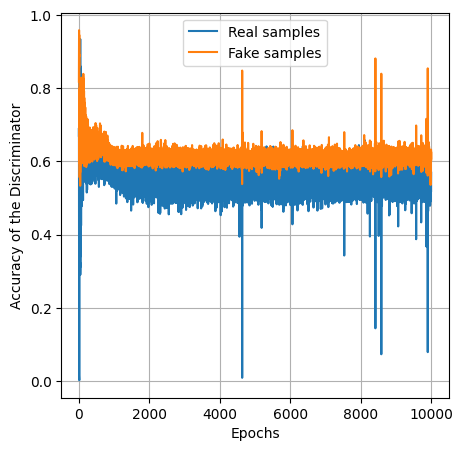

In [ ]:
gan = GAN(
    latent_dim=50,
    lr=0.0002,
    beta_1=0.5,
    out_folder='final',
    disc_acc_limits=(0.6, 0.85),
    alpha=0.2,
    momentum=0.8,
    dropout=0.25,
    img_best_search=1)

gan.train(
    X_train=X_train,
    epochs=10000,
    batch_size=512,
    sample_interval=100,
    save_interval=100)

gan.plot_losses()
gan.plot_acc()

282/282 [==============================] - 1s 2ms/step


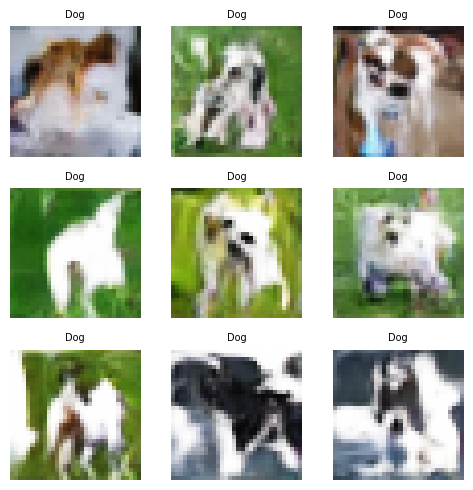

In [ ]:
gan.sample_images(grid_size=(3,3), search_best=1000)

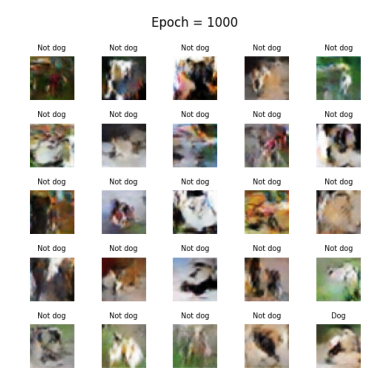

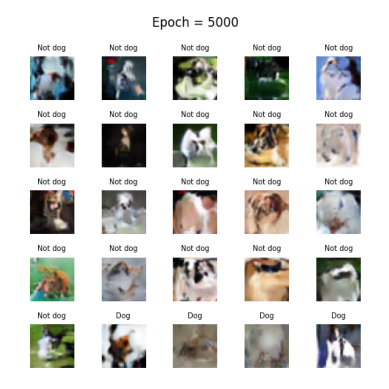

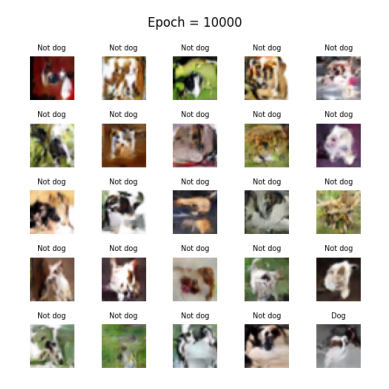

In [ ]:
gan.show_image(1000)
gan.show_image(5000)
gan.show_image(10000)